# Wikimedia Data Scraping: UK Parliamentary Consituencies
#### Coursework for DS105A: Data for Data Science

**Importing Necessary Packages and Libraries**

In [1]:
import re # as suggested by ChatGPT for my 2nd Scrape (more details in that section)
import requests
import pandas as pd

from pprint import pprint
from scrapy import Selector

In [2]:
to_scrape = "https://en.wikipedia.org/w/index.php?advancedSearch-current={%22fields%22:{%22intitle%22:%22UK%20Parliament%20constituency%22}}&limit=3000&offset=0&profile=default&search=intitle%3A%22UK+Parliament+constituency%22&title=Special:Search&ns0=1&p=1"
headers = {'User-Agent' : 'Summative3 (victoriaelizabethdent@gmail.com)'}
response = requests.get(to_scrape, headers)
sel = Selector(text=response.text)

#### 1st Scrape: Constituency Names and Links
The Wikipedia search above returns all pages with '(UK Parliamentary constituency)' in the title, which includes current and abolished constituencies, as well as any other pages with that content. I filtered out these other pages using a for-loop, and created a data frame called 'allConstituencies', which holds the titles and links to all UK Parliamentary constituencies, ever.

In [642]:
container = sel.css("div.mw-search-results-container")

wanted_links = []
wanted_titles = []
all_links = container.css('a ::attr(href)').getall()
all_titles = container.css('a ::attr(title)').getall()
for i in range(len(all_titles)):
    if "(UK Parliament constituency)"  in all_titles[i]:
        if all_titles[i] not in wanted_titles:
            wanted_titles.append(all_titles[i])
            wanted_links.append(all_links[i])
wanted_titles = [wanted_titles[i].replace(' (UK Parliament constituency)', '') for i in range(len(wanted_titles))]

for i in range(len(wanted_links)):
    wanted_links[i] = "https://en.wikipedia.org/" + wanted_links[i]

df_all_constituencies = pd.DataFrame({
    'Constituency Titles': wanted_titles,
    'Links': wanted_links,
})

df_all_constituencies.to_csv('./data/all_constituencies.csv')


#### 2nd Scrape: Existing vs. Abolished Constituencies
In my second notebook, NB02 - Simple Explanatory Analysis, I plan to provide some analysis on both current and abolished constituencies. Therefore, it is important that I distinguish between the two types, so I scraped a list of current constituencies from Wikipedia, and turned this into a list of current constituencies, against which I can check my list of _all_ constituencies which I gained from scraping my search. As there are two types of constituency (Abolished or Not Abolished), I used the Boolean data type.

_**(From this point onwards, I decided against gaining information on the active years of now-abolished constituencies, due to this being a short project)**_

##### ...And Constituencies' Countries
To gain national insights into the data, I thought it pertinent to identify the country the constituency is in.

In [643]:
# scraping the wikipedia page which has lists of all 650 current constituencies from each country in the UK
scraping_current = "https://en.wikipedia.org/wiki/Constituencies_of_the_Parliament_of_the_United_Kingdom"
response = requests.get(scraping_current, headers)
sel = Selector(text=response.text)

# ----- IDENTIFYING IF A CONSTITUENCY IS ACTIVE OR HAS BEEN ABOLISHED ----- #

# then, i am directly accessing the tables with the constituency information by referring to their HTML ids
# i am putting this information into a dataFrame called 'constituencies'
constituencies_list = []
tables = sel.css('table#England, table#Scotland, table#Wales, table#NI').getall()
for i in range(len(tables)):
    dfs = pd.read_html(tables[i])[0]
    constituencies_list.append(dfs)
constituencies = pd.concat(constituencies_list)

# next, i wanted to gain a list of all the names of the current constituencies 
# this is so i can compare them to my large list of all constituencies.
current_constituencies = constituencies['Constituency'].values.tolist()

def processing(list, for_value):    # this function converts strings in 'list' to be lowercase with no whitespace or punctuation (ChatGPT)
    for i in range(len(for_value)):
        list.append(re.sub(r'\W', '', for_value[i].lower()))

processed_titles = []   # a processed list of all the names of constituencies (abolished and active)
processing(processed_titles, wanted_titles)

processed_constituencies = []   # a processed list of all the names of active constituencies
processing(processed_constituencies, current_constituencies)

current = []
for i in range(len(processed_titles)):
    if processed_titles[i] in processed_constituencies:
        current.append(False)
    else:
        current.append(True)

# ----- IDENTIFYING A CONSTITUENCY'S COUNTRY ----- #

england_list = []
processed_england = []

england_tables = sel.css('table#England').getall()
for i in range(len(england_tables)):
    df = pd.read_html(england_tables[i])[0]
    england_list.append(df)
e_constituencies = pd.concat(england_list)
england_list = e_constituencies['Constituency'].values.tolist()
processing(processed_england, england_list)

scotland_list = []
processed_scotland = []

scotland_tables = sel.css('table#Scotland').getall()
for i in range(len(scotland_tables)):
    df = pd.read_html(scotland_tables[i])[0]
    scotland_list.append(df)
s_constituencies = pd.concat(scotland_list)
scotland_list = s_constituencies['Constituency'].values.tolist()
processing(processed_scotland, scotland_list)

wales_list = []
processed_wales = []

wales_tables = sel.css('table#Wales').getall()
for i in range(len(wales_tables)):
    df = pd.read_html(wales_tables[i])[0]
    wales_list.append(df)
w_constituencies = pd.concat(wales_list)
wales_list = w_constituencies['Constituency'].values.tolist()
processing(processed_wales, wales_list)

ni_list = []
processed_ni = []

ni_tables = sel.css('table#NI').getall()
for i in range(len(ni_tables)):
    df = pd.read_html(ni_tables[i])[0]
    ni_list.append(df)
ni_constituencies = pd.concat(ni_list)
ni_list = ni_constituencies['Constituency'].values.tolist()
processing(processed_ni, ni_list)

countries = []
for i in range(len(processed_titles)):
        if processed_titles[i] in processed_england:
                countries.append('England')
        elif processed_titles[i] in processed_scotland:
                countries.append('Scotland')
        elif processed_titles[i] in processed_wales:
                countries.append('Wales')
        elif processed_titles[i] in processed_ni:
                countries.append('Northern Ireland')
        else:
                countries.append("")

df_all_constituencies['Abolished'] = current
df_all_constituencies['Country'] = countries
df_all_constituencies.to_csv('./data/all_constituencies.csv', index = False)

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/3950469697.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(tables[i])[0]
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/3950469697.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(tables[i])[0]
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/3950469697.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(tables[i])[0]
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/3950469697.py:13: FutureWarning: Passing literal html to 'read_html' is de

#### 3rd Scrape: Electorate Size
I would like to gain some information regarding the size of the electorate (i.e how many people are registered to vote) in a constituency. If available, these figures are stored on the constituency's page, in a table next to the main text of the article, as seen below. I would like to use this data to do some calculations regarding the percentage of voters in different constituencies, and even across the nations. This data is imperative to finding these results.

![Screenshot 2023-11-13 at 15.45.49.png](<attachment:Screenshot 2023-11-13 at 15.45.49.png>)
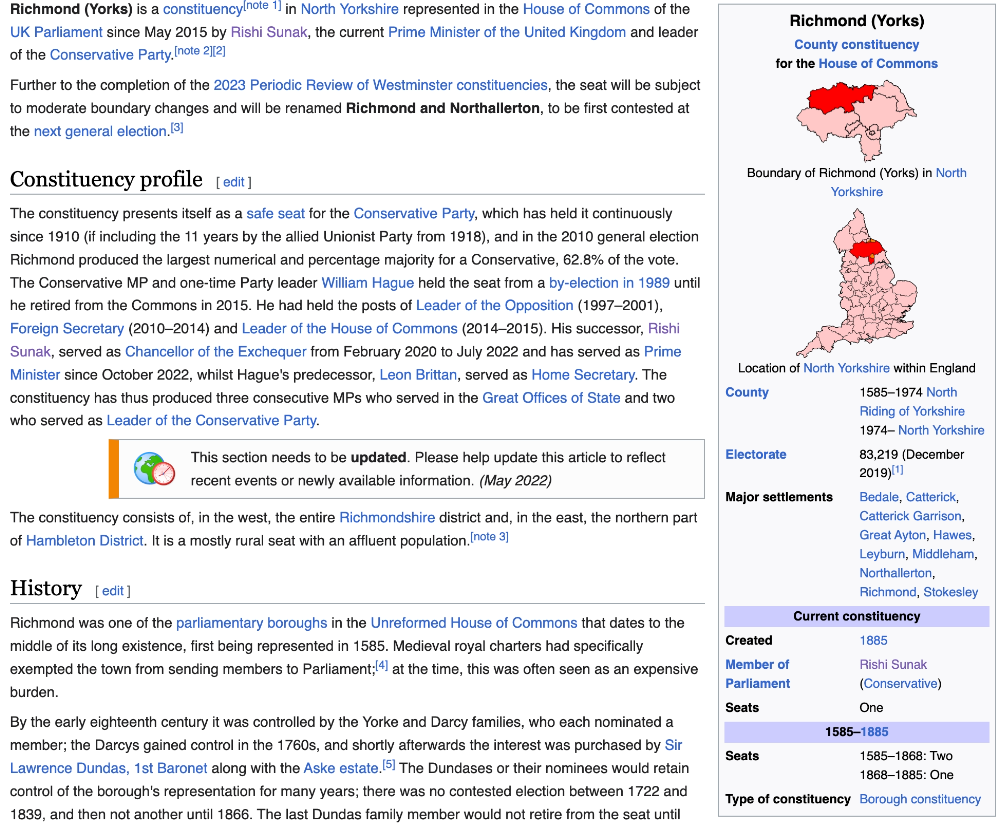

In [644]:
electorate_size = []
for i in range(len(df_all_constituencies)):
    if current[i] == False:
        response = requests.get(wanted_links[i], headers)
        sel = Selector(text=response.text)
        infobox = sel.css('table.infobox.vcard')

        info_data = infobox.css('td.infobox-data').xpath('string()').getall()   # code from ChatGPT, as I CSS selectors did not return what I desired   
        info_label = infobox.css('th.infobox-label ::text').getall()
        
        if "Electorate" in info_label:
            for j in range(len(info_label)):
                if info_label[j] == "Electorate":
                    possible_electorate = info_data[j].replace(',', '')
                    possible_electorate = possible_electorate.split()[0]
                    if possible_electorate.isdigit():
                        # print(f"{possible_electorate} is a number.")
                        electorate_size.append(possible_electorate)
                    else:
                        electorate_size.append("")
        else: # (when there is no electorate data for this constituency in the sidebar pictured above)
            electorate_size.append("")
    
    else:
        electorate_size.append("")

df_all_constituencies['Electorate Size'] = electorate_size
df_all_constituencies.to_csv('./data/all_constituencies.csv', index = False)

### 4th Scrape: (Most Recent) Election Turnout
In order to gain the data I expressed my desire to collect (above), I would also like to gain the turnout variable.

For most constituencies, turnout was last counted during the 2019 General Election

In [645]:
turnout = []
for i in range(len(df_all_constituencies)):
    if current[i] == False:
        response = requests.get(wanted_links[i], headers)
        sel = Selector(text=response.text)
        
        election_column_titles = []
        desired_column_titles = ['Party', 'Candidate', 'Votes']
        tables = sel.css('table.wikitable.plainrowheaders').getall()

        largest = float('-inf')
        df = pd.read_html(tables[0])[0].values.tolist()
        for j in range(len(df)):
            for k in range(len(df[j])):
                try:
                    value = float(df[j][k])
                    if value > largest:
                        largest = value
                except ValueError:
                    pass

        if largest != float('-inf'):
            turnout.append(largest)
        else:
            turnout.append("")
   
    else:
        turnout.append("")
    
df_all_constituencies["(Most Recent) Turnout"] = turnout
df_all_constituencies.to_csv('./data/all_constituencies.csv', index = False)


/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/645727016.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(tables[0])[0].values.tolist()
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/645727016.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(tables[0])[0].values.tolist()
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/645727016.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(tables[0])[0].values.tolist()
/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_50017/645727016.py:12: FutureWarning: 

#### _Attempted_ Final Scrape: Information on Each Constituency's Member of Parliament
Again, in my second notebook, I plan to provide an analyis of the Members of Parliament - hopefully resulting in some interesting statistics regarding gender, age and education as well as the length of time they have served as MP of their current constituency. In order to do this, I will scrape each active (not abolished) constituency's own Wikipedia page for the table shown below, and gain information about their current MP (the last row of the table).

_**I have included this code in my notebook, despite the unsuccessful outcome, as I spent a substantial amount of time trying to scrape this table.**_

![Screenshot 2023-11-12 at 00.55.20.png](<attachment:Screenshot 2023-11-12 at 00.55.20.png>)
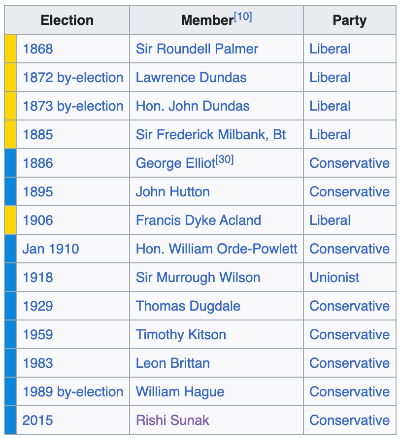

In [646]:
# current_MP = []
# current_name = []
# current_party = []
# current_voted = []
# key_terms = ['election', 'member', 'party']
# for i in range(len(df_all_constituencies)):
    # if current[i] == False:
    #     response = requests.get(wanted_links[i], headers)
    #     sel = Selector(text=response.text)
        
    #     column_titles = []
    #     tables = sel.css('table.wikitable').getall()
    #     for i in range(len(tables)):
    #         this_table = Selector(text=tables[i])
    #         column_titles.append(this_table.css('th ::text').getall())

    #     final_columns = []
    #     for i in range(len(column_titles)):
    #         processed_columns = []
    #         for j in range(len(column_titles[i])):
    #             processed_columns.append(re.sub(r'\W', '', column_titles[i][j].lower()))
    #         final_columns.append(processed_columns)

    #     for i in range(len(final_columns)):
    #         if ('election' in final_columns[i]) and ('member' in final_columns[i]) and ('party' in final_columns[i]):
    #             tables[i] = tables[i].replace('”', '"')
    #             desired_table = tables[i]
    #             df = pd.read_html(desired_table)[0]
    #             df_cleaned = df.dropna(axis=1, thresh=len(df))
    #             final_df = df_cleaned.dropna()
    #             current_MP = final_df.iloc[-1].tolist()
    #     if len(currentMP) >= 3:
    #         current_name.append(currentMP[1])
    #         current_party.append(currentMP[2])                
    #         current_voted.append(currentMP[0])
    #     else:
    #         current_name.append("")
    #         current_party.append("")
    #         current_voted.append("")
    #         break

    # else:
    #     # abolished constituency - no current MP
    #     current_name.append("")
    #     current_party.append("")
    #     current_voted.append("")    

# df_all_constituencies['Current MP'] = current_name
# df_all_constituencies['Party'] = current_party
# df_all_constituencies['Voted In'] = current_voted
    
# df_all_constituencies.to_csv('./data/all_constituencies.csv', index = False)

### Lastly, Data Organisation

The final part of data collection is organisation in a way that is most condusive to my analysis.

First, for my own ease, I would like to rearrange the columns of my DataFrame to be alphabetical via constituency title.

In [647]:
df_all_constituencies = df_all_constituencies.reindex(sorted(df_all_constituencies.columns), axis=1)

Then, it would make analysing my collected data easier if I converted some of the numerical data into the 'integer' datatype. 

The variables I would like to change to integers are 'Electorate Size' and 'Election Turnout'

In [648]:
df_all_constituencies = pd.read_csv('./data/all_constituencies.csv',
                 dtype={'Election Size': float,
                        '(Most Recent) Turnout': float},
                 na_values=['']) # this turn all empty strings in NaN values
